In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import csv
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [27]:
df = pd.read_json('reviews_Movies_and_TV_5.json', lines=True)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0005019281,"[0, 0]",4,This is a charming version of the classic Dick...,"02 26, 2008",ADZPIG9QOCDG5,"Alice L. Larson ""alice-loves-books""",good version of a classic,1203984000
1,0005019281,"[0, 0]",3,It was good but not as emotionally moving as t...,"12 30, 2013",A35947ZP82G7JH,Amarah Strack,Good but not as moving,1388361600
2,0005019281,"[0, 0]",3,"Don't get me wrong, Winkler is a wonderful cha...","12 30, 2013",A3UORV8A9D5L2E,Amazon Customer,Winkler's Performance was ok at best!,1388361600
3,0005019281,"[0, 0]",5,Henry Winkler is very good in this twist on th...,"02 13, 2008",A1VKW06X1O2X7V,"Amazon Customer ""Softmill""",It's an enjoyable twist on the classic story,1202860800
4,0005019281,"[0, 0]",4,This is one of the best Scrooge movies out. H...,"12 22, 2013",A3R27T4HADWFFJ,BABE,Best Scrooge yet,1387670400


In [28]:
df2 = df[pd.notnull(df['reviewText'])]

1088752

In [29]:
df_asin_review_text = df2[['asin','reviewText']]
df_asin_review_count = df_asin_review_text.groupby("asin", as_index=False).count()

df_knn = df_asin_review_count[df_asin_review_count.reviewText >=100]
df_sentiment = df_asin_review_count[df_asin_review_count.reviewText  < 100]

final_df_knn = df2.loc[df2['asin'].isin(df_knn['asin'])]

final_df_sentiment = df2.loc[df2['asin'].isin(df_sentiment['asin'])]

final_df_knn.to_json('final_df_knn.json')
final_df_sentiment.to_json('final_df_sentiment.json')

In [30]:
len(final_df_knn)

809924

In [31]:
len(final_df_sentiment)

887609

In [32]:
len(df2)

final_df_sentiment.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
109,0005119367,"[1, 1]",4,"A truly wonderfully made film, mostly accurate...","07 6, 2006",AJSYTZQVJJOYW,A. Abela,Wonderful!!!,1152144000
110,0005119367,"[1, 1]",5,Joseph is amazing story to read and watch. A ...,"05 1, 2010",A1QNGKV688Q8TE,Aaron D. Koehler,Joseph,1272672000
111,0005119367,"[4, 4]",5,This WONDERFUL film is a total treat on every ...,"03 15, 2005",A36311XF4O81IK,A. J. Trivette,As real as it gets!,1110844800
112,0005119367,"[102, 106]",5,Though this interpretation of Joseph's life ha...,"02 21, 2004",AQ8DU6XVA3USJ,"Alejandra Vernon ""artist & illustrator""",a man of character and faith,1077321600
113,0005119367,"[1, 1]",5,I loved this story about Joseph. It's one of m...,"01 22, 2009",A1ZLFCUF4XX7RZ,Alex,True Faith,1232582400


In [33]:
final_df_sentiment = final_df_sentiment.reindex(columns=['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName','summary','unixReviewTime','numerator','denominator'])
final_df_sentiment.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,numerator,denominator
109,0005119367,"[1, 1]",4,"A truly wonderfully made film, mostly accurate...","07 6, 2006",AJSYTZQVJJOYW,A. Abela,Wonderful!!!,1152144000,NaN,NaN
110,0005119367,"[1, 1]",5,Joseph is amazing story to read and watch. A ...,"05 1, 2010",A1QNGKV688Q8TE,Aaron D. Koehler,Joseph,1272672000,NaN,NaN
111,0005119367,"[4, 4]",5,This WONDERFUL film is a total treat on every ...,"03 15, 2005",A36311XF4O81IK,A. J. Trivette,As real as it gets!,1110844800,NaN,NaN
112,0005119367,"[102, 106]",5,Though this interpretation of Joseph's life ha...,"02 21, 2004",AQ8DU6XVA3USJ,"Alejandra Vernon ""artist & illustrator""",a man of character and faith,1077321600,NaN,NaN
113,0005119367,"[1, 1]",5,I loved this story about Joseph. It's one of m...,"01 22, 2009",A1ZLFCUF4XX7RZ,Alex,True Faith,1232582400,NaN,NaN


In [34]:
final_df_sentiment[['numerator','denominator']] = pd.DataFrame(final_df_sentiment.helpful.values.tolist(), index= final_df_sentiment.index)

In [35]:
final_df_sentiment.to_json('final_df_sentiment.json')

In [36]:
final_df_sentiment = (final_df_sentiment[final_df_sentiment['denominator'] > 0])
final_df_sentiment = final_df_sentiment[final_df_sentiment['numerator'] / final_df_sentiment['denominator'] >= 0.8] 

In [37]:
len(final_df_sentiment)

304084

In [12]:
final_df_sentiment.to_json('final_df_sentiment.json')

In [13]:
rating_review = final_df_sentiment[['reviewText','overall']]

In [14]:
rating_review.head()

,reviewText,overall
109,"A truly wonderfully made film, mostly accurate...",4
110,Joseph is amazing story to read and watch. A ...,5
111,This WONDERFUL film is a total treat on every ...,5
112,Though this interpretation of Joseph's life ha...,5
113,I loved this story about Joseph. It's one of m...,5


In [15]:
rating_review["opinion"] = rating_review["overall"].apply(lambda value: "good" if value >= 3 else "bad")
final_df_knn["opinion"] = final_df_knn["overall"].apply(lambda value: "good" if value >= 3 else "bad")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
rating_review[rating_review.overall == 4].head(3)

,reviewText,overall,opinion
109,"A truly wonderfully made film, mostly accurate...",4,good
166,"I liked this movie, except one scene where Pot...",4,good
191,This four hour video looks a the familiar &quo...,4,good


In [17]:
rating_review["reviewText"].head(3)

109    A truly wonderfully made film, mostly accurate...
110    Joseph is amazing story to read and watch.  A ...
111    This WONDERFUL film is a total treat on every ...
Name: reviewText, dtype: object

In [18]:
regular_expression = re.compile('[^a-z]+')
def process_text(review_text):
    review_text = review_text.lower()
    review_text = regular_expression.sub(' ', review_text).strip()
    return review_text

rating_review["processedReview"] = rating_review["reviewText"].apply(process_text)
final_df_knn["processedReview"] = final_df_knn["reviewText"].apply(process_text)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
final_df_knn.to_json('final_df_knn_after_removing_spaces.json')
rating_review.to_json('rating_review.json')

In [61]:
rating_review = rating_review.drop(['reviewText', 'overall'],1)

In [20]:
rating_review.head()

,reviewText,overall,opinion,processedReview
109,"A truly wonderfully made film, mostly accurate...",4,good,a truly wonderfully made film mostly accurate ...
110,Joseph is amazing story to read and watch. A ...,5,good,joseph is amazing story to read and watch a pe...
111,This WONDERFUL film is a total treat on every ...,5,good,this wonderful film is a total treat on every ...
112,Though this interpretation of Joseph's life ha...,5,good,though this interpretation of joseph s life ha...
113,I loved this story about Joseph. It's one of m...,5,good,i loved this story about joseph it s one of my...


In [21]:
train_data = rating_review

In [22]:
(len(train_data), len(final_df_knn))

(304084, 809924)

In [23]:
print len(train_data)

304084


In [24]:
#CountVectorizer to get bag of words model
count_vectorizer = CountVectorizer(min_df = 1, ngram_range = (1, 2))
X_train_bags = count_vectorizer.fit_transform(train_data["processedReview"])

#tfidf to bag of words
tfidf_transformer = TfidfTransformer()
X_train_data = tfidf_transformer.fit_transform(X_train_bags)

Y_train_data = train_data["opinion"]
Y_test_knn_data = final_df_knn["opinion"]
predicted_output = dict();

In [25]:
X_test_counts = count_vectorizer.transform(final_df_knn["processedReview"])
X_test_knn_data = tfidf_transformer.transform(X_test_counts)

In [26]:
def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

save_sparse_csr("X_train_data",X_train_data)
save_sparse_csr("X_test_knn_data",X_test_knn_data)
Y_test_knn_data.to_csv("Y_test_knn_data.csv")

In [27]:
Y_train_data.to_csv("Y_train_data.csv")

In [102]:
# Y_train_data = Series.from_csv('Y_train_data.csv')
# X_train_data = load_sparse_csr("X_train_data")
# X_test_knn_data = load_sparse_csr("X_test_knn_data")
# Y_test_knn_data = Series.from_csv('Y_test_knn_data.csv')

In [29]:
type(Y_train_data)

pandas.core.series.Series

In [ ]:
arr = [1,10,100,1000,10000,100000,1000000,10000000,100000000]
accuracy_arr = []
for c in arr:
    logistic_regres = LogisticRegression(C=c)
    output_model_log = logistic_regres.fit(X_train_data, Y_train_data)
    predicted_output['logistic'] = logistic_regres.predict(X_test_knn_data)
    accuracy_arr.append(accuracy_score(Y_test_knn_data, predicted_output['logistic']))
    

In [ ]:
print accuracy_arr

In [71]:
logistic_regres = LogisticRegression(C=1e5)
output_model_log = logistic_regres.fit(X_train_data, Y_train_data)
predicted_output['logistic'] = logistic_regres.predict(X_test_knn_data)

In [31]:
accuracy_score(Y_test_knn_data, predicted_output['logistic'])

0.9241867138151234

In [32]:
output = logistic_regres.predict_proba(X_test_knn_data)

In [33]:
output_in_5  = output[:,1]*5

In [34]:
# predicted_rating = test_output['logistic'][:,1]*5
final_df_knn["predicted_rating"] = output_in_5;
final_df_knn.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,opinion,processedReview,predicted_rating
0,0005019281,"[0, 0]",4,This is a charming version of the classic Dick...,"02 26, 2008",ADZPIG9QOCDG5,"Alice L. Larson ""alice-loves-books""",good version of a classic,1203984000,good,this is a charming version of the classic dick...,4.999999
1,0005019281,"[0, 0]",3,It was good but not as emotionally moving as t...,"12 30, 2013",A35947ZP82G7JH,Amarah Strack,Good but not as moving,1388361600,good,it was good but not as emotionally moving as t...,4.997966
2,0005019281,"[0, 0]",3,"Don't get me wrong, Winkler is a wonderful cha...","12 30, 2013",A3UORV8A9D5L2E,Amazon Customer,Winkler's Performance was ok at best!,1388361600,good,don t get me wrong winkler is a wonderful char...,2.979760
3,0005019281,"[0, 0]",5,Henry Winkler is very good in this twist on th...,"02 13, 2008",A1VKW06X1O2X7V,"Amazon Customer ""Softmill""",It's an enjoyable twist on the classic story,1202860800,good,henry winkler is very good in this twist on th...,4.998769
4,0005019281,"[0, 0]",4,This is one of the best Scrooge movies out. H...,"12 22, 2013",A3R27T4HADWFFJ,BABE,Best Scrooge yet,1387670400,good,this is one of the best scrooge movies out hen...,5.000000


In [88]:
final_df_knn.to_json('final_result_after_logistic.json')

In [112]:
final_df_knn.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,opinion,processedReview,predicted_rating
0,0005019281,"[0, 0]",4,This is a charming version of the classic Dick...,"02 26, 2008",ADZPIG9QOCDG5,"Alice L. Larson ""alice-loves-books""",good version of a classic,1203984000,good,this is a charming version of the classic dick...,5.000000
1,0005019281,"[0, 0]",3,It was good but not as emotionally moving as t...,"12 30, 2013",A35947ZP82G7JH,Amarah Strack,Good but not as moving,1388361600,good,it was good but not as emotionally moving as t...,4.999790
2,0005019281,"[0, 0]",3,"Don't get me wrong, Winkler is a wonderful cha...","12 30, 2013",A3UORV8A9D5L2E,Amazon Customer,Winkler's Performance was ok at best!,1388361600,good,don t get me wrong winkler is a wonderful char...,4.617876
3,0005019281,"[0, 0]",5,Henry Winkler is very good in this twist on th...,"02 13, 2008",A1VKW06X1O2X7V,"Amazon Customer ""Softmill""",It's an enjoyable twist on the classic story,1202860800,good,henry winkler is very good in this twist on th...,4.999957
4,0005019281,"[0, 0]",4,This is one of the best Scrooge movies out. H...,"12 22, 2013",A3R27T4HADWFFJ,BABE,Best Scrooge yet,1387670400,good,this is one of the best scrooge movies out hen...,5.000000


In [35]:
final_df_knn['predicted_rating'].corr(final_df_knn['overall'])

0.6050956285668032

In [41]:
final_df_knn.head(3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,opinion,processedReview,predicted_rating
0,0005019281,"[0, 0]",4,This is a charming version of the classic Dick...,"02 26, 2008",ADZPIG9QOCDG5,"Alice L. Larson ""alice-loves-books""",good version of a classic,1203984000,good,this is a charming version of the classic dick...,4.999999
1,0005019281,"[0, 0]",3,It was good but not as emotionally moving as t...,"12 30, 2013",A35947ZP82G7JH,Amarah Strack,Good but not as moving,1388361600,good,it was good but not as emotionally moving as t...,4.997966
2,0005019281,"[0, 0]",3,"Don't get me wrong, Winkler is a wonderful cha...","12 30, 2013",A3UORV8A9D5L2E,Amazon Customer,Winkler's Performance was ok at best!,1388361600,good,don t get me wrong winkler is a wonderful char...,2.979760


In [42]:
final_df_knn.tail(10)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,opinion,processedReview,predicted_rating
1696522,B00JBBJJ24,"[0, 0]",4,My husband and I watched it a few days ago and...,"07 14, 2014",AWOR72TWT6CA2,TSKPP,Good movie,1405296000,good,my husband and i watched it a few days ago and...,4.999991
1696523,B00JBBJJ24,"[6, 7]",5,Loosely based on a French graphic novel series...,"04 5, 2014",ABO2ZI2Y5DQ9T,Tsuyoshi,(4.5 STARS) Sci-Fi Thriller That Keeps You Gue...,1396656000,good,loosely based on a french graphic novel series...,5.000000
1696524,B00JBBJJ24,"[2, 2]",4,Just when you thought trains were boring and a...,"07 5, 2014",A4YXKE5F62II8,Visual Bureau,Bizarre yet intriguing and action-packed dysto...,1404518400,good,just when you thought trains were boring and a...,4.999999
1696525,B00JBBJJ24,"[0, 0]",5,An ingenious new twist with a reality that spa...,"07 16, 2014",A25PBENDNUAZ1E,"V. Taylor ""Valharley""",Great Entertainment!,1405468800,good,an ingenious new twist with a reality that spa...,5.000000
1696526,B00JBBJJ24,"[2, 5]",3,"Considering the reviews, I expected more from ...","07 12, 2014",ADWSD45P3NZGU,WakkyWabbit,Mediocre at best,1405123200,good,considering the reviews i expected more from t...,5.000000
1696527,B00JBBJJ24,"[0, 0]",4,Joon Ho-Bong returns with a memorable (and one...,"07 12, 2014",AQP1VPK16SVWM,"Wayne Klein ""If at first the idea is not absu...","Minor flaws aside, ""Snowpiercer"" is an ambitio...",1405123200,good,joon ho bong returns with a memorable and one ...,5.000000
1696528,B00JBBJJ24,"[0, 0]",3,Fair movie for a -B flic.,"07 20, 2014",A3N0AIL901L11Z,"W. F. Knapp ""Diamond""",- B at best.,1405814400,good,fair movie for a b flic,4.986345
1696529,B00JBBJJ24,"[3, 3]",4,"""Snowpiercer"" offers a lot to like. The man-ma...","07 8, 2014",AUTBHG6070SL4,"wiredweird ""wiredweird""",Great after-collapse story,1404777600,good,snowpiercer offers a lot to like the man made ...,4.999966
1696530,B00JBBJJ24,"[1, 4]",1,This is a silly movie with a ridiculous plot. ...,"07 20, 2014",A1B6QP9DKH4QZJ,W. R. Friedlaender,Not a good movie,1405814400,bad,this is a silly movie with a ridiculous plot i...,0.351937
1696531,B00JBBJJ24,"[0, 0]",4,Solid movie making no matter the country which...,"07 18, 2014",A3OD04P0A831WB,yongbing1,Snowpiecer is a Rare Movie: Entertaing and Tho...,1405641600,good,solid movie making no matter the country which...,4.999987


In [44]:
predicted_output = dict();
model = BernoulliNB().fit(X_train_data, Y_train_data)
predicted_output['Bernoulli'] = model.predict(X_test_knn_data)
accuracy_score(Y_test_knn_data, predicted_output['Bernoulli'])

0.8771847728922714

In [45]:
predicted_output = dict();
model = MultinomialNB().fit(X_train_data, Y_train_data)
predicted_output['Multinomial'] = model.predict(X_test_knn_data)
accuracy_score(Y_test_knn_data, predicted_output['Multinomial'])

0.8772020584647449

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=250,
        max_font_size=35, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

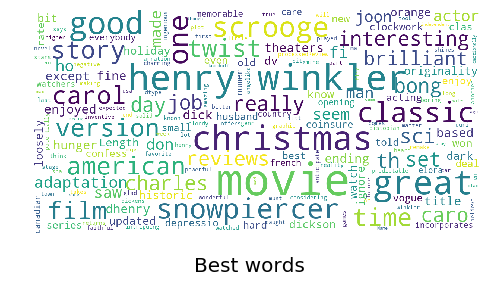

In [69]:
show_wordcloud(final_df_knn[final_df_knn.predicted_rating >=4]["processedReview"], title = "Best words")

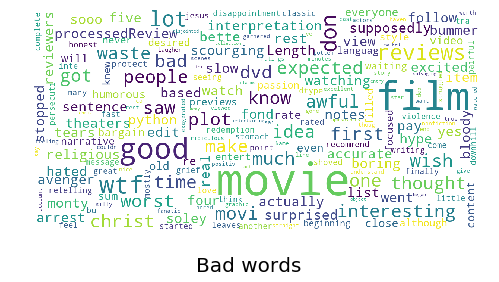

In [70]:
show_wordcloud(final_df_knn[final_df_knn.predicted_rating <=2]["processedReview"], title = "Bad words")

In [4]:
a = pd.read_json('final_result_after_logistic.json')

In [21]:
d = a[abs(a['overall'] - a['predicted_rating']) >2]

In [22]:
d

,asin,helpful,opinion,overall,predicted_rating,processedReview,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
1000001,B000GAKLZI,"[0, 3]",bad,1,4.999926,everything about this movie was outstanding th...,Everything about this movie was outstanding.;t...,"04 8, 2014",A2L0C6QQWLC3JB,Carolyn Francisco,Amazing movie version of the Broadway production.,1396915200
1000029,B000GAKLZI,"[0, 0]",bad,3,0.639658,this could have been the greatest movie musica...,This could have been the greatest movie musica...,"03 29, 2013",AH6MA8WLB3GDV,CLP,Almost awesome,1364515200
1000054,B000GAKLZI,"[0, 0]",bad,1,4.999313,charles laughton and frederick march will need...,Charles Laughton and Frederick March will need...,"10 4, 2013",A3UCT83QM8N71X,Dan Duncan,One star disappoointment,1380844800
1000057,B000GAKLZI,"[0, 0]",bad,2,4.627491,from the first trailer showing anne hathaway s...,"From the first trailer, showing Anne Hathaway ...","06 5, 2013",AE62TIY3899YL,"Daniel J. Silva ""Superman_242""",A bold feat that falls flat,1370390400
1000070,B000GAKLZI,"[5, 9]",bad,2,4.340436,this latest production of les miserables just ...,This latest production of Les Miserables just ...,"03 24, 2013",AGDZRJPC6P584,david mathers,"visually beautiful, but...",1364083200
100008,0790732254,"[6, 40]",bad,1,4.999971,then watch this movie if you don t have enough...,Then watch this movie. If you don't have enoug...,"03 28, 2011",ADY5TAAMS20MI,"Anne Bronte ""&#34;Diana&#34;""",If you like depression...,1301270400
1000094,B000GAKLZI,"[6, 9]",bad,1,4.851841,the plus people who gave this disgraceful movi...,The 1400 plus people who gave this disgraceful...,"09 29, 2013",A2RETJZ8461X5L,dj,AWFUL,1380412800
1000096,B000GAKLZI,"[4, 4]",bad,1,4.951185,boring simple leaves you empty limps along the...,"BORING ......SIMPLE,,,,,LEAVES you empty.....L...","12 11, 2013",A3Q4TL88MBGLLI,D. Katz,"WOW..,,what an extreme letdown,,,,GO SEE THE P...",1386720000
1000099,B000GAKLZI,"[0, 1]",bad,1,4.880258,i m not a theater buff and i don t like opera ...,"I'm not a theater buff, and I don't like Opera...","01 22, 2014",AKWE0F620RRNV,D. Myerscough,Singing for no reason!,1390348800
1000145,B000GAKLZI,"[2, 4]",bad,3,0.032585,les miserables seems unsure if it s a musical ...,Les Miserables seems unsure if it's a musical ...,"07 9, 2013",AQZH7YTWQPOBE,Enjolras,musical or movie?,1373328000


In [19]:
d['reviewText'][1]

u'It was good but not as emotionally moving as the the Christmas Carol by Dickens  I like Christmas movies that make me sigh'

In [26]:
d['reviewText'][100008]

u"Then watch this movie. If you don't have enough marital discord and vicious fighting in your life, watch this. If you like scenes where two married people wait on the front porch while their spouses cheat upstairs (nothing graphic), watch this. If you like watching people drink (actors drinking fake drinks) for 24+ hours straight with no other food or other beverages, and stagger around the yard mumbling, then this is the movie for you. If you like having to strain to hear what they're saying, even better. If you love two hours and 15 minutes of unabated misery, in dismal black and white, then this movie is for you! If you like feeling dragged in to their ugliness and feel ugly yourself when you're done, then you will love this movie. Enjoy!"